# Reads a single float and uses the meteo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob
import seawater as sw
from soccom_functions import *
import pickle 
import datetime

## Reads float data

In [2]:
#reads float data
file_folder = "../../data/raw/"
#file_folder = "../../data/raw/LowRes"
float_number = "9094" #7900918 #9094

files = sorted(glob.glob(file_folder+"/*"+float_number+"*.nc"))
print(files)
#files = sorted(glob.glob(file_folder+"/*.nc"))

['../../data/raw\\9094SOOCN_HRQC.nc']


In [4]:
#uses the function that reads and grids the data
FLOAT = grids_one_buoy(files[0],display_info = False, DO_ml_crit = 2.5, clear_short = True)

#the gridded data is located in the dictionary FLOAT.gr, and contains the following variables
print(FLOAT.gr.keys())
#some of them are standard and others related to thorpe scales and mixing, and you also have geopotential anomalies (gpa) integrated between 500 and 1500 m (gpa_500_1500)

print("This float is WMO code: %s"%(FLOAT.gr["WMO_code"]))


#fmet = open("float_pickles/ERA_hr_"+FLOAT.raw["code"]+".pi","rb")
#FLOAT.methr = pickle.load( fmet )
#FLOAT.methr["time64"] = np.copy( FLOAT.methr["time"] )
#FLOAT.methr["time"] = convert_datetime64_to_time(FLOAT.methr["time64"])
#FLOAT.methr["date"] = convert_datetime64_to_date(FLOAT.methr["time64"])
#FLOAT.calculates_carbon_framework(sp = FLOAT.methr["sp"], timemet = FLOAT.methr["time"], ML_zero = False)
#CFvars = FLOAT.gr["CF"].keys()

#carbon flux
#FLOAT.calculates_CO2_O2_flux(FLOAT.methr)

dict_keys(['depth', 'date', 'Lon', 'Lat', 'code', 'WMO_code', 'Pressure', 'Temperature', 'Salinity', 'SA', 'CT', 'Sigma_theta', 'gamma_n', 'N2', 'PV', 'Oxygen', 'OxygenSat', 'Nitrate', 'DIC_LIAR', 'TALK_LIAR', 'pCO2_LIAR', 'Chla_corr', 'POC', 'LT', 'mld', 'mld_HT', 'mld_DO', 'LT_ml', 'LT_ov', 'LT_largest_ov', 'size_largest_ov', 'h_largest_ov', 'h_no_ov', 'gpa', 'gpa_500_1500', 'AOU'])
This float is WMO code: 5904471


In [5]:
#plt.plot(FLOAT.gr["date"], FLOAT.gr["FCO2_all"],".")

KeyError: 'FCO2_all'

## Initial plot of the float main variables and position

C:\anaconda\anaconda3\envs\argo_ncp\lib\site-packages\matplotlib\contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\anaconda\anaconda3\envs\argo_ncp\lib\site-packages\matplotlib\contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


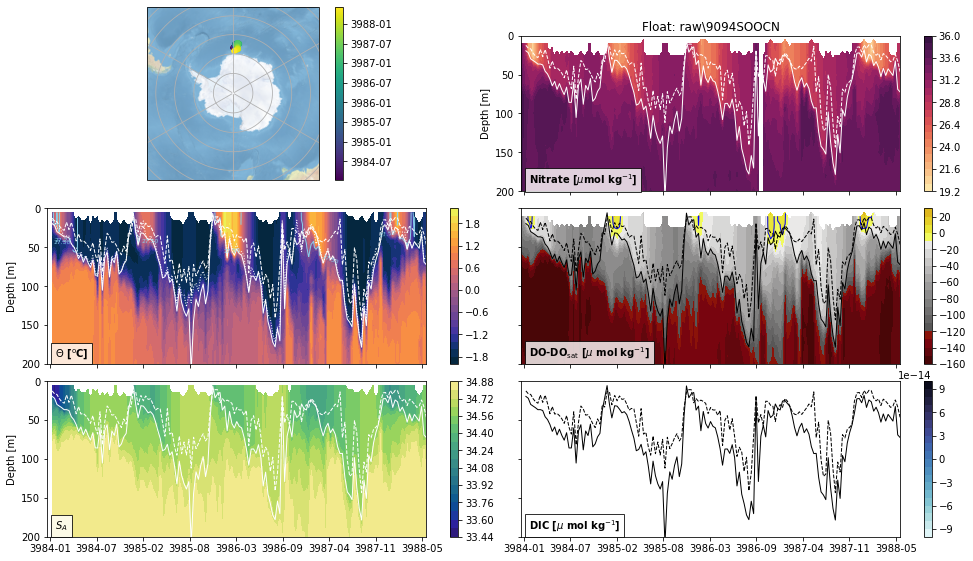

In [14]:
%matplotlib inline 
# qt
#with this command you can have an overview of the float data 
FLOAT.plots_map_main_variables(shows = True, saves = False, ylim=  (200,0))
#FLOAT.plots_mixing_layer_profile(20, show = True)

#plt.plot(FLOAT.gr["date"],FLOAT.gr["gpa_500_1500"])

## Nitrate uptake

Deepest mixed layer: 209 m
-125786228.51762265
[False False  True  True  True False]

-------------------------------------------------------------------------
YEAR	    NEP Nit	     <NEP Nit>	      NEP POC	      <NEP POC>
				 [mol/m2/yr]
-------------------------------------------------------------------------
2014-2015	 nan		nan		nan		nan
2015-2016	 3.41		3.10		0.31		0.33
2016-2017	 3.47		2.92		0.58		0.51
2017-2018	 4.79		4.01		0.95		0.77
2018-2019	 3.25		2.36		0.90		0.88
2019-2020	 nan		nan		nan		nan
-------------------------------------------------------------------------
Mean     	3.73		3.10		0.68		0.62
-------------------------------------------------------------------------


C:\Users\CLARAD~1\AppData\Local\Temp/ipykernel_9276/865690136.py:21: RuntimeWarning: Mean of empty slice
  dint_Nitrate = np.nanmean(FLOAT.gr["Nitrate"][:jh,:], axis = 0)*H*(1027/1e6)
C:\Users\CLARAD~1\AppData\Local\Temp/ipykernel_9276/865690136.py:23: RuntimeWarning: Mean of empty slice
  mSA = np.nanmean( FLOAT.gr["SA"][FLOAT.gr["depth"]>500,:], axis = 0 )


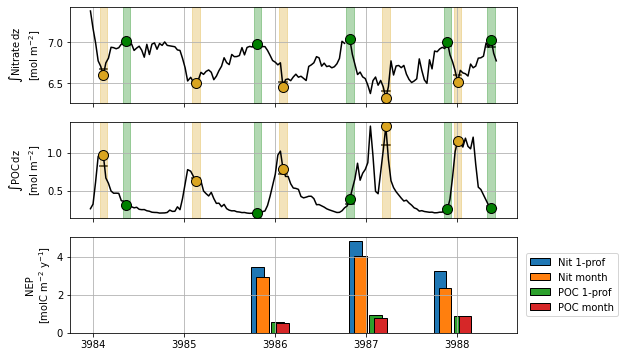

In [15]:
#first I convert the numerical date to a datetime format so I can get the month and year vectors
RCN = 106/16. # Redfield ratio

nt = FLOAT.gr["date"].size
dateDT = convert_time_to_date( FLOAT.gr["date"] )
year = np.full( nt, np.nan )
month = np.full(nt, np.nan)
for i in range(nt):
    year[i] = dateDT[i].year
    month[i] = dateDT[i].month

H = np.nanmax(FLOAT.gr["mld"]) # calculates the maximum ML
##### YOU COULD OVER-RIDE IT BY UN-COMMENTING
#H = 200.

print("Deepest mixed layer: %1.0f m"%(H))
jh = np.where( FLOAT.gr["depth"]>= H)[0][0] # gets the depth index for the maxmum mixed layer
print(np.nanmean(FLOAT.gr["Lat"]))

#depth integrated nitrate/POC
dint_Nitrate = np.nanmean(FLOAT.gr["Nitrate"][:jh,:], axis = 0)*H*(1027/1e6)
dint_POC = np.nanmean(FLOAT.gr["POC"][:jh,:], axis = 0)*H/1000.
mSA = np.nanmean( FLOAT.gr["SA"][FLOAT.gr["depth"]>500,:], axis = 0 )
#by multiplying by density ~1027 and dividing by 1e6 I get units mol m-2

#for each year calculates the maximum and minimum
Uyear = np.unique(year)
nyr = Uyear.size
date_nit_sum = np.full(nyr, np.nan)
date_nit_win = np.full(nyr, np.nan)
nit_win = np.full(nyr, np.nan)
nit_sum = np.full(nyr, np.nan)
nit_win_month_avg = np.full(nyr, np.nan)
nit_sum_month_avg = np.full(nyr, np.nan)

POC_win = np.full(nyr, np.nan)
POC_sum = np.full(nyr, np.nan)
POC_win_month_avg = np.full(nyr, np.nan)
POC_sum_month_avg = np.full(nyr, np.nan)

SA_win = np.full(nyr, np.nan)
SA_sum = np.full(nyr, np.nan)
Lat_win = np.full(nyr, np.nan)
Lat_sum = np.full(nyr, np.nan)
Lon_win = np.full(nyr, np.nan)
Lon_sum = np.full(nyr, np.nan)
flag_nit_NEP = np.full(nyr, False)
for i, yr in enumerate(Uyear):
    start_summer = datetime.datetime(int(yr),12,1,0,0).toordinal()
    end_summer = datetime.datetime(int(yr)+1,4,1,0,0).toordinal()
    it_summer = np.where( (FLOAT.gr["date"]>= start_summer) & (FLOAT.gr["date"]<= end_summer) )[0]
    if it_summer.size > 0:
        if np.sum(np.isfinite(dint_Nitrate[it_summer]))>0:
            imin_nit = it_summer[ np.nanargmin( dint_Nitrate[it_summer] ) ]
            date_nit_sum[i] = FLOAT.gr["date"][imin_nit]  
            nit_sum[i] =np.nanmin( dint_Nitrate[it_summer])
            POC_sum[i] = dint_POC[imin_nit]
            #ii_sum_month = np.where( np.abs(FLOAT.gr["date"] - FLOAT.gr["date"][imin_nit]  )<15 )[0]
            ii_sum_month = np.where( (month == month[imin_nit]) & (year == year[imin_nit])   )[0]
            nit_sum_month_avg[i] =np.nanmean( dint_Nitrate[ii_sum_month])
            POC_sum_month_avg[i] =np.nanmean( dint_POC[ii_sum_month])
            SA_sum[i] = mSA[imin_nit]
            Lat_sum[i] = FLOAT.gr["Lat"][imin_nit]
            Lon_sum[i] = FLOAT.gr["Lon"][imin_nit]
        
    start_winter = datetime.datetime(int(yr),5,1,0,0).toordinal()
    end_winter = datetime.datetime(int(yr),12,1,0,0).toordinal()
    it_winter = np.where( (FLOAT.gr["date"]>= start_winter) & (FLOAT.gr["date"]<= end_winter) )[0]
    if it_winter.size > 0:
        if np.sum(np.isfinite(dint_Nitrate[it_winter]))>0:
            imax_nit = it_winter[ np.nanargmax( dint_Nitrate[it_winter] ) ]
            date_nit_win[i] = FLOAT.gr["date"][imax_nit]  
            nit_win[i] = np.nanmax( dint_Nitrate[it_winter])
            POC_win[i] =  dint_POC[imax_nit]
            #ii_win_month = np.where( np.abs(FLOAT.gr["date"] - FLOAT.gr["date"][imax_nit]  )<15 )[0]
            ii_win_month = np.where( (month == month[imax_nit]) &  (year == year[imax_nit])   )[0]
            nit_win_month_avg[i] =np.nanmean( dint_Nitrate[ii_win_month])
            POC_win_month_avg[i] =np.nanmean( dint_POC[ii_win_month])
            SA_win[i] = mSA[imax_nit]
            Lat_win[i] = FLOAT.gr["Lat"][imax_nit]
            Lon_win[i] = FLOAT.gr["Lon"][imax_nit]

flag_nit_NEP = (np.abs(date_nit_win-date_nit_sum)<8*30) & (np.abs(SA_win-SA_sum)<0.05) & (np.abs(Lon_win-Lon_sum)<8.) & (np.abs(Lat_win-Lat_sum)<5.)
print(flag_nit_NEP)
        

#calculates net ecosystem production (molC m-2 yr-1)
NEP = (nit_win - nit_sum)*RCN
#from the monthly means
NEP_avg = (nit_win_month_avg - nit_sum_month_avg)*RCN

NEP_POC = -(POC_win - POC_sum)
NEP_POC_avg = -(POC_win_month_avg - POC_sum_month_avg)

#gets the date around the depletion
date_NEP = 0.5*(date_nit_sum +date_nit_win )
Lon_NEP = 0.5*(Lon_win+Lon_sum)
Lat_NEP = 0.5*(Lat_win+Lat_sum)

#Plots the results 
fig, ax = plt.subplots(3,1,figsize = (8,6), sharex = True)
ax[0].plot( FLOAT.gr["date"], dint_Nitrate, "k" )
l1,=ax[0].plot(date_nit_sum, nit_sum,"o", ms = 10, mec = "k", color = "goldenrod")
l2,=ax[0].plot(date_nit_win, nit_win,"o", ms = 10, mec = "k", color = "green")
for i in range(nyr):
    ax[0].plot([date_nit_sum[i]-15,date_nit_sum[i]+15], [nit_sum_month_avg[i],nit_sum_month_avg[i]], color = "k", zorder = -1)
    ax[0].plot([date_nit_win[i]-15,date_nit_win[i]+15], [nit_win_month_avg[i],nit_win_month_avg[i]], zorder = -1, color = "k")
yl = ax[0].get_ylim()
for i in range(nyr):
    ax[0].fill_between( [date_nit_sum[i]-15,date_nit_sum[i]+15], y1 = yl[0], y2 = yl[1], color = l1.get_color(), alpha = 0.3 )
    ax[0].fill_between( [date_nit_win[i]-15,date_nit_win[i]+15], y1 = yl[0], y2 = yl[1], color = l2.get_color(), alpha = 0.3 )

ax[0].set_ylim(yl)
ax[0].set_ylabel( "$\\int \\mathrm{Nitrate}\, \\rm d z$\n[mol m$^{-2}$]" )
ax[0].grid(True)


ax[1].plot( FLOAT.gr["date"], dint_POC, "k" )
l1,=ax[1].plot(date_nit_sum, POC_sum,"o", ms = 10, mec = "k", color = "goldenrod")
l2,=ax[1].plot(date_nit_win, POC_win,"o", ms = 10, mec = "k", color = "green")
for i in range(nyr):
    ax[1].plot([date_nit_sum[i]-15,date_nit_sum[i]+15], [POC_sum_month_avg[i],POC_sum_month_avg[i]], color = "k", zorder = -1)
    ax[1].plot([date_nit_win[i]-15,date_nit_win[i]+15], [POC_win_month_avg[i],POC_win_month_avg[i]], zorder = -1, color = "k")
yl = ax[1].get_ylim()
for i in range(nyr):
    ax[1].fill_between( [date_nit_sum[i]-15,date_nit_sum[i]+15], y1 = yl[0], y2 = yl[1], color = l1.get_color(), alpha = 0.3 )
    ax[1].fill_between( [date_nit_win[i]-15,date_nit_win[i]+15], y1 = yl[0], y2 = yl[1], color = l2.get_color(), alpha = 0.3 )

ax[1].set_ylim(yl)
ax[1].set_ylabel( "$\\int \\mathrm{POC}\, \\rm d z$\n[mol m$^{-2}$]" )
ax[1].grid(True)

ax[2].bar( date_NEP[flag_nit_NEP]-50, NEP[flag_nit_NEP], width = 50, ec = "k", label = "Nit 1-prof"  )
ax[2].bar( date_NEP[flag_nit_NEP]-30, NEP_avg[flag_nit_NEP], width = 50, ec = "k", label = "Nit month" )
ax[2].bar( date_NEP[flag_nit_NEP]+30, NEP_POC[flag_nit_NEP], width = 50, ec = "k", label = "POC 1-prof"  )
ax[2].bar( date_NEP[flag_nit_NEP]+50, NEP_POC_avg[flag_nit_NEP], width = 50, ec = "k", label = "POC month" )
ax[2].set_ylabel("NEP\n[molC m$^{-2}$ y$^{-1}$]")
ax[2].legend(loc = "center left", bbox_to_anchor = (1.01,0.5))
formatter = mdates.DateFormatter("%Y") ### formatter of the date
locator = mdates.YearLocator() ### where to put the labels
ax[2].xaxis.set_major_locator(locator)
ax[2].xaxis.set_major_formatter(formatter)
ax[2].grid(True)



print( "\n-------------------------------------------------------------------------")
print("YEAR\t    NEP Nit\t     <NEP Nit>\t      NEP POC\t      <NEP POC>" )
print("\t\t\t\t [mol/m2/yr]")
print( "-------------------------------------------------------------------------")
for i in range(nyr):
    print("%d-%d\t %1.2f\t\t%1.2f\t\t%1.2f\t\t%1.2f"%(Uyear[i],Uyear[i]+1, NEP[i], NEP_avg[i], NEP_POC[i], NEP_POC_avg[i])  )
print( "-------------------------------------------------------------------------")
print("Mean     \t%1.2f\t\t%1.2f\t\t%1.2f\t\t%1.2f"%(np.nanmean(NEP), np.nanmean(NEP_avg),np.nanmean(NEP_POC), np.nanmean(NEP_POC_avg)))
print( "-------------------------------------------------------------------------")

As you see the averages are slightly different, not sure why, probably due to a combination of interpolation for gridding the nitrate and also the vertical integration

# Oxygen consumption

In [ ]:
RCO = - 106./170.
maxz = 500.
minz = 100.
z= np.copy(FLOAT.gr["depth"])
dz = z[1]-z[0]
jh = np.where((z>=minz) & (z<=maxz))[0]


#depth integrated O2
dint_O2 = moving_average( np.nanmean(FLOAT.gr["Oxygen"][jh,:], axis = 0),10)
mSA = np.nanmean( FLOAT.gr["SA"][FLOAT.gr["depth"]>500,:], axis = 0 )

O2 = np.copy(FLOAT.gr["Oxygen"])
nz, nt = O2.shape
for j in range(nz):
    O2[j,:] = moving_average(O2[j,:],10)


zM = np.tile(z,(nt,1)).T
mldM = np.tile(FLOAT.gr["mld"],(nz,1))
ismld = zM<mldM
O2[ismld] = np.nan


#for each year calculates the maximum and minimum
Uyear = np.unique(year)
nyr = Uyear.size
date_O2_sum = np.full(nyr, np.nan)
date_O2_win = np.full(nyr, np.nan)
R_O2 = np.full(nyr, np.nan)

SA_O2_win = np.full(nyr, np.nan)
SA_O2_sum = np.full(nyr, np.nan)
Lat_O2_win = np.full(nyr, np.nan)
Lat_O2_sum = np.full(nyr, np.nan)
Lon_O2_win = np.full(nyr, np.nan)
Lon_O2_sum = np.full(nyr, np.nan)

for i, yr in enumerate(Uyear):
    start_winter = datetime.datetime(int(yr),8,1,0,0).toordinal()
    end_winter = datetime.datetime(int(yr),12,1,0,0).toordinal()
    it_winter = np.where( (FLOAT.gr["date"]>= start_winter) & (FLOAT.gr["date"]<= end_winter) )[0]
    imax_O2 = np.nan
    imin_O2 = np.nan
    if it_winter.size > 0:
        if np.sum(np.isfinite(dint_O2[it_winter]))>0:
            imax_O2 = it_winter[ np.nanargmax( dint_O2[it_winter] ) ]
            
    start_summer = datetime.datetime(int(yr)+1,1,1,0,0).toordinal()
    end_summer = datetime.datetime(int(yr)+1,4,1,0,0).toordinal()
    it_summer = np.where( (FLOAT.gr["date"]>= start_summer) & (FLOAT.gr["date"]<= end_summer) )[0]
    if it_summer.size > 0:
        if np.sum(np.isfinite(dint_O2[it_summer]))>0:
            imin_O2 = it_summer[ np.nanargmin( dint_O2[it_summer] ) ]

    if np.isfinite(imin_O2) and np.isfinite(imax_O2) and (imin_O2>imax_O2):
        iiy = np.arange( imax_O2, imin_O2+1  )
        dO2dt = np.full(nz, np.nan)
        for j in jh:
            ox = O2[j,iiy]
            time = FLOAT.gr["date"][iiy]
            iif = np.isfinite(ox)
            time = time[iif]
            ox = ox[iif]
            plt.plot(time,ox)
            p = np.polyfit(time,ox,1)
            #print(p[0])
            dO2dt[j] = p[0]*(time[-1]-time[0])
        R_O2[i] =  np.nansum( 0.5*(dO2dt[1:]+dO2dt[:-1])*1027*1e-6*RCO*(z[1:]-z[:-1]))#np.nansum(dz*dO2dt*1027*1e-6)*RCO
        date_O2_win[i] = FLOAT.gr["date"][imax_O2]  
        SA_O2_win[i] = mSA[imax_O2]
        Lat_O2_win[i] = FLOAT.gr["Lat"][imax_O2]
        Lon_O2_win[i] = FLOAT.gr["Lon"][imax_O2]
        date_O2_sum[i] = FLOAT.gr["date"][imin_O2]  
        SA_O2_sum[i] = mSA[imin_O2]
        Lat_O2_sum[i] = FLOAT.gr["Lat"][imin_O2]
        Lon_O2_sum[i] = FLOAT.gr["Lon"][imin_O2]

flag_O2_R = (np.abs(date_O2_win-date_O2_sum)>3*30) & (np.abs(SA_O2_win-SA_O2_sum)<0.05) & (np.abs(Lon_O2_win-Lon_O2_sum)<8.) & (np.abs(Lat_O2_win-Lat_O2_sum)<5.)        
        #plt.plot(FLOAT.gr["date"][iiy],O2[::5,:].T)
date_R = 0.5*(date_O2_sum +date_O2_win )
Lon_R = 0.5*(Lon_O2_win+Lon_O2_sum)
Lat_R = 0.5*(Lat_O2_win+Lat_O2_sum)

print(R_O2)
print(flag_O2_R)
print(np.nanmean(R_O2[flag_O2_R]))
    
fig, ax = plt.subplots(2,1,figsize = (8,5), sharex = True)  
ax[0].plot(FLOAT.gr["date"], dint_O2,"k")
yl = ax[0].get_ylim()
for i in range(date_O2_sum.size):
    ax[0].fill_between( [date_O2_win[i], date_O2_sum[i]], y1 = yl[0], y2 = yl[1],color = "gray" )
ax[0].set_ylim(yl)
ax[0].set_ylabel("$\\langle \\mathrm{Oxygen} \\rangle$ [$\\mu$mol kg $^{-1}$]")
ax[1].bar( date_R[flag_O2_R], R_O2[flag_O2_R], width = 50, ec = "k" )
ax[1].set_ylabel("R\n[molC m$^{-2}$ y$^{-1}$]")
#ax[1].legend(loc = "center left", bbox_to_anchor = (1.01,0.5))
formatter = mdates.DateFormatter("%Y") ### formatter of the date
locator = mdates.YearLocator() ### where to put the labels
ax[1].xaxis.set_major_locator(locator)
ax[1].xaxis.set_major_formatter(formatter)
ax[1].grid(True)
